# Import

In [1]:
import tarfile
import os
# import pandas as pd
from loguru import logger
# from openbabel import openbabel
# import rdkit.Chem as ch
import pandas as pd
from rdkit import rdBase, Chem, DataStructs
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem.AtomPairs import Pairs, Torsions
from rdkit.Chem.Draw import SimilarityMaps
from data.tools import utils


In [37]:
# """path"""
#
# WORK_DIR = os.path.curdir
# DEBUG_DIR = os.path.join(WORK_DIR,'debug')
# # @TODO argparse data path
#
#
# """FOR DEBUG"""
# DATA_ROOT = os.path.join(DEBUG_DIR,'example')
# TMP_DIR = os.path.join(DEBUG_DIR,'tmp')
# if not os.path.isdir(TMP_DIR):
#     os.makedirs(TMP_DIR)
# OUT_DIR = os.path.join(DEBUG_DIR,'output')
#
# """logging"""
#
# DEBUG = True
#
# LOG_DIR = os.path.join(WORK_DIR,'log')
# if not os.path.exists(LOG_DIR):
#     os.makedirs(LOG_DIR)
#
# LOG_FILE = os.path.join(LOG_DIR,'debug_{time}.log')
#
# logger.add(LOG_FILE,retention=2)
#
# if DEBUG:
#     logger.debug('debug data directory: {}'.format(DEBUG_DIR))

ModuleNotFoundError: No module named 'win32_setctime'

# Step 1: preprocess
## Tar Extractor

import tarfile

dir_1 = './debug/example/AA/'
tar_1 = os.path.join(dir_1, 'AABAAC.tar')
dir_2 = os.path.join(TMP_DIR, 'AABAAC')
tar_2_gz =  os.path.join(dir_2, '00000.tar.gz')

with  tarfile.open(tar_1) as tar:
    tar.extractall(TMP_DIR)
    names = tar.getnames()


In [22]:
# from tqdm import tqdm
#
# for d in os.listdir(DATA_ROOT):
#     # d: "AA"
#     d_path = os.path.join(DATA_ROOT,d)
#     for f in tqdm(os.listdir(d_path)):
#         # f: "AABAAC.tar"
#         # if i == 2: break
#         """critical section"""
#         with tarfile.open(os.path.join(d_path,f)) as tf:
#             names = tf.getnames()
#             # name: "AABAAC/00000.tar.gz,...."
#             tf.extractall(TMP_DIR)
#             # to "tmp/AABAAC/00000.tar.gz"
#
#         for name in names:
#             # name: "AABAAC"
#             dirname = os.path.dirname(name)
#             with tarfile.open(os.path.join(TMP_DIR, name)) as tf:
#                 tf.extractall(os.path.join(TMP_DIR, dirname))

100%|██████████| 204/204 [00:18<00:00, 11.08it/s]


## Format Converter

In [39]:
import openbabel
# def file_convert(inputFile, outputFile, inFormat='pdbqt', outFormat='sdf'):
#     conv= openbabel.OBConversion("debug/tmp/AABABD/00000/Z18500480_1_T1.pdbqt", "debug/Z18500480_1_T1.smiles")
#     conv.OpenInAndOutFiles("pdbqt","smiles")
#     conv.Convert()
#     conv.CloseOutFile()

In [20]:
# input_file = "debug/tmp/AABABD/00000/Z18500480_1_T1.pdbqt"
# os.path.dirname(input_file)
# os.path.splitext(os.path.basename(input_file))[0]+'.smiles'
#
# # os.path.ex

'Z18500480_1_T1.smiles'

In [1]:
# from  data.tools import utils, converter
#
# with utils.tmpdir_manager('./debug') as tmp_dir:
#     tar_extractor = extractor.Extractor(
#             data_dir='./debug/example',
#             n_cpu=1)
#     converter = converter.Converter(tmp_dir, 'pdbqt', 'sdf')
#     tar_extractor.extract(tmp_dir)
#     for d_1 in os.listdir(tmp_dir):
#         logger.info(d_1)
#         for d_2 in os.listdir(os.path.join(os.path.dirname(tmp_dir),d_1)):
#             logger.info(d_2)
#             for pdbqt_file in os.listdir(d_2):
#             #     logger.info(pdbqt_file)

ModuleNotFoundError: No module named 'loguru'

## rdkit mol
指纹就是一些key的组合，输出可以是BitVect，以节省空间

In [2]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem as ch
import matplotlib.pyplot as plt  # 画图

supp = Chem.SDMolSupplier('./debug/Z18500480_1_T1.sdf')
bi = {}
mols_fps_Morgen = [(m, ch.GetMorganFingerprintAsBitVect(m, radius=2, bitInfo=bi)) for m in supp]
print(bi)


{314: ((2, 1),), 370: ((5, 2),), 475: ((0, 1),), 576: ((5, 0),), 623: ((11, 2),), 650: ((2, 0), (12, 0)), 666: ((11, 1),), 674: ((8, 0),), 738: ((5, 1),), 771: ((1, 1),), 807: ((7, 0), (11, 0)), 856: ((4, 1),), 881: ((10, 0),), 906: ((9, 1), (13, 1)), 935: ((0, 0), (3, 0)), 1037: ((4, 0), (9, 0), (13, 0)), 1102: ((10, 1),), 1145: ((6, 1),), 1199: ((6, 2),), 1209: ((8, 2),), 1263: ((1, 2),), 1370: ((10, 2),), 1380: ((1, 0), (6, 0)), 1602: ((7, 1),), 1610: ((3, 1),), 1659: ((8, 1),), 1705: ((0, 2),), 1917: ((12, 1),), 2006: ((3, 2),)}


## 一个很好用的SimilarityMap

In [88]:
from rdkit.Chem.Draw import SimilarityMaps

# 目标分子
targetmol = Chem.MolFromSmiles(
    'COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
# 参考分子
refmol = Chem.MolFromSmiles('CCCN(CCCCN1CCN(c2ccccc2OC)CC1)Cc1ccc2ccccc2c1')

Draw.MolDraw2DSVG(400, 400)
d.ClearDrawing()
target_mol_simi_fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(
    refmol,
    targetmol,
    lambda m, i: SimilarityMaps.GetMorganFingerprint(
        m, i, radius=2, fpType='bv'),
    draw2d=d
)
print(target_mol_simi_fig)  # Figure(250x250)
print(maxweight)  # 0.12255947497949138
d.FinishDrawing()
with open('./mol28.svg', 'w+') as outf:
    outf.write(d.GetDrawingText())
# d.ClearDrawing()

0.12255947497949138


In [5]:
from rdkit.DataStructs import ExplicitBitVect, CreateFromBinaryText
m = Chem.MolFromSmiles(
    'COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
bi = {}
fp = ch.GetMorganFingerprintAsBitVect(m, radius=2)
fp = ch.GetMACCSKeysFingerprint(m)
base64 = ExplicitBitVect.ToBase64(fp)
print(base64)

# _fp = ExplicitBitVect.
_fp = ExplicitBitVect(0)
ExplicitBitVect.FromBase64(_fp, base64)

with open('./mol1','w+') as f:
    f.write(base64)
print(_fp.ToBase64())
# fp.FromBase64(base64)


4P///6cAAAA8AAAAcggEDAQGAAIAAgAGAAAAAgACAgAEAAgAAgYAAgAABAAAAAAGAgIABgACAAAABAAAAAAAAAAAAAAAAAAAAg==
4P///6cAAAA8AAAAcggEDAQGAAIAAgAGAAAAAgACAgAEAAgAAgYAAgAABAAAAAAGAgIABgACAAAABAAAAAAAAAAAAAAAAAAAAg==


In [193]:
from data.tools import utils
tmp_dir = os.path.join(os.path.curdir,'debug','tmp')
# with utils.tmpdir_manager() as tmp_dir:

for i, d_1 in enumerate(os.listdir(tmp_dir)):
    if i > 1: break
    dpath_1 = os.path.join(tmp_dir, d_1)
    for d_2 in os.listdir(dpath_1):
        dpath_2 = os.path.join(dpath_1, d_2)
        if os.path.isdir(dpath_2):
            for f in os.listdir(dpath_2):
                logger.info(os.path.join(dpath_2, f))
                logger.info(os.path.splitext(f)[0])
                # logger.debug(f)



2022-07-03 22:22:40.017 | INFO     | __main__:<module>:12 - .\debug\tmp\AABAAC\00000\Z1252751589_1_T1.pdbqt
2022-07-03 22:22:40.018 | INFO     | __main__:<module>:13 - Z1252751589_1_T1
2022-07-03 22:22:40.018 | INFO     | __main__:<module>:12 - .\debug\tmp\AABAAC\00000\Z1509950178_1_T1.pdbqt
2022-07-03 22:22:40.018 | INFO     | __main__:<module>:13 - Z1509950178_1_T1
2022-07-03 22:22:40.020 | INFO     | __main__:<module>:12 - .\debug\tmp\AABAAC\00000\Z1510155714_1_T1.pdbqt
2022-07-03 22:22:40.020 | INFO     | __main__:<module>:13 - Z1510155714_1_T1
2022-07-03 22:22:40.021 | INFO     | __main__:<module>:12 - .\debug\tmp\AABAAC\00000\Z1614339982_1_T1.pdbqt
2022-07-03 22:22:40.021 | INFO     | __main__:<module>:13 - Z1614339982_1_T1
2022-07-03 22:22:40.022 | INFO     | __main__:<module>:12 - .\debug\tmp\AABAAC\00000\Z1692816331_1_T1.pdbqt
2022-07-03 22:22:40.022 | INFO     | __main__:<module>:13 - Z1692816331_1_T1
2022-07-03 22:22:40.022 | INFO     | __main__:<module>:12 - .\debug\tmp\AAB

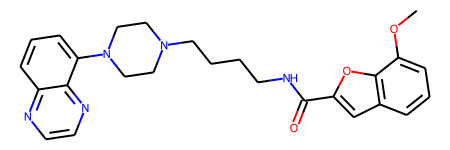

In [93]:
targetmol

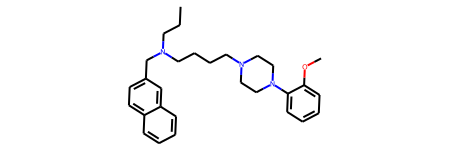

In [94]:
refmol

In [2]:
with utils.tmpdir_manager() as tmp_dir:
    tar_extractor = extractor.Extractor(
        data_dir='./debug/example',
        n_cpu=1)
    tar_extractor.extract(tmp_dir)

NameError: name 'utils' is not defined

In [12]:
full_path = './tmp6uq2a4pi/AABAAC/00000/Z1252751589_1_T1.sdf'
dirname = os.path.dirname(full_path)
basename = os.path.basename(full_path)

file_id = os.path.splitext(basename)[0]
file_id


pdbqt转fp

In [211]:
from data.tools.pipeline import  _pdbqt2fingerprint
from data.tools import pipeline

path = os.path.join('tmpycuut84t', 'AABBAC', '00000')
# out = os.path.join('tmp93eb8ia2','out')
os.makedirs('out')
for f in os.listdir(path):
    # print(f)
    file_id = os.path.splitext(f)[0]
    _pdbqt2fingerprint(path, file_id, '.sdf', 'out')

In [10]:
from meeko import PDBQTMolecule
from openbabel import openbabel

path='tmpbqzs_1_d/AABCAF/00000'
file_id = 'Z1692919946_1_T1.pdbqt'
in_full_path = os.path.join(path, file_id)
out_full_path = 'Z1692919946_1_T1.sdf'
conv = openbabel.OBConversion(in_full_path, out_full_path)
conv.OpenInAndOutFiles('.pdbqt','.smiles')
conv.Convert()
conv.CloseOutFile()

['Z1252751589_1_T1',
 'Z1509950178_1_T1',
 'Z1510155714_1_T1',
 'Z1614339982_1_T1',
 'Z1692816331_1_T1',
 'Z1692816331_2_T1',
 'Z2027307024_1_T1',
 'Z2027307024_1_T2',
 'Z2027307024_1_T3',
 'Z2499074481_1_T1',
 'Z2499074481_1_T2',
 'Z2499074481_1_T3',
 'Z2890544298_1_T1',
 'Z2890544298_2_T1',
 'Z2977592255_1_T1',
 'Z2980972959_1_T1']

In [62]:
a = os.path.splitext(os.path.join(path, file_id))[0]
os.path.basename(a)

In [80]:
os.path.basename(os.path.join(path, file_id))

'Z1692919946_1_T1'

In [78]:
from data.tools.pipeline import _cal_single_fingerprint
from openbabel import pybel
path='tmpbqzs_1_d/AABCAF/00000'
file_id = 'Z1692919946_1_T1.pdbqt'
in_full_path = os.path.join(path, file_id)
f = pybel.readfile('pdbqt',in_full_path)
mol = f.__next__()
print(mol.write("sdf", 'mol1.sdf',overwrite=True))
print(mol.write("smiles", 'mol1.smi', overwrite=True))
f.close()

# _cal_single_fingerprint(dir_path, file_id, 'smiles')

'Z1692919946_1_T1.pdbqt'

In [12]:
from rdkit import Chem
sup = Chem.SDMolSupplier("mol1.sdf")
sup = Chem.SmilesMolSupplier("mol1.smi", titleLine=1, smilesColumn=1 )
mol = sup.__next__()
mol

None
None


In [1]:
from scripts.rdkit2pdbqt import MolFromPDBQTBlock,MolToPDBQTBlock

MolToPDBQTBlock(mol)
with open("tmpbqzs_1_d/AABCAF/00000/Z1692919946_1_T1.pdbqt") as f:
    mol = MolFromPDBQTBlock(f.read())
mol

RuntimeError: File parsing error: ERROR: Index error (idx = 0): ran out of lines


In [70]:
from rdkit.Chem import AllChem
import os
from openbabel import pybel
from rdkit import Chem

f = pybel.readfile('smiles','mo2.smiles')
smi_str = f.__next__().write().split('\t')[0]
mol = Chem.MolFromSmiles(smi_str)

fp = AllChem.GetMACCSKeysFingerprint(mol)
macc_base64 = fp.ToBase64()
fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2)
morgan_base64 = fp.ToBase64()
print(macc_base64, morgan_base64)

4P///6cAAAAgAAAAkAQIBAAADAQAABgMBgAADggAAgACBgIEBAIAAAACBAAC 4P///wAIAAAZAAAAJGqG8F6ecAUAknEAPkpyuQB4SAadAIrshQDijgbwCg==


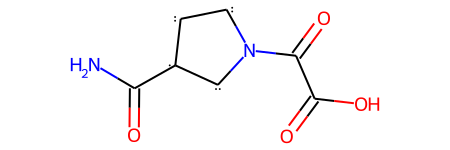

In [14]:
# smi_str
Chem.SmilesMolSupplierFromText('CO')


那么上面这段就说明，pybel造的格式只有自己看得懂，SmilesMolSupplier看不懂，那么就用pybel的read，然后转为smiles字符串读取。
2022年7月8日15:19:25 smiles转换失败率太高了...

删除output

In [5]:
import shutil

out_dir = './debug/output'
shutil.rmtree(out_dir, ignore_errors=True)

下面这几段，发现有些没转化成功的就是因为坐标重合了，或者是直接是空的
3w个里有差不多30个左右吧

In [37]:
import  glob
import pandas as pd
df_fp = pd.DataFrame([os.path.splitext(os.path.basename(i))[0] for i in glob.glob('./debug/output/*.fp')])
df_pdbqt = pd.DataFrame([os.path.splitext(os.path.basename(i))[0] for i in glob.glob(r'./tmp626uhmgx/**/*.pdbqt', recursive=True)])

In [60]:
df_fp.head()
df_pdbqt.head()
df_error = df_pdbqt.append(pd.DataFrame.merge(df_fp, df_pdbqt)).drop_duplicates(keep=False).reset_index(drop=True)
# for i in df_error[0
# ]:
paths = []
for i in df_error[0]:
    paths.extend(glob.glob(r'./tmp626uhmgx/**/{}.pdbqt'.format(i), recursive=True))
for path in paths:
    with open(path, 'r') as f:
        print(f.read())


REMARK    Small molecule (ligand)
REMARK    Compound: Z2916152125_3_T1
REMARK    SMILES: CN1C[C@@H]2CC[C@@H](C1)N2C(=O)C(N)=O
REMARK    The ligand was originally not a salt, therefore no desalting was carried out.
REMARK    The tautomeric state was generated by cxcalc version 18.20.0 of ChemAxons JChem Suite.
REMARK    Protonation state was generated at pH 7.4 by cxcalc version 18.20.0 of ChemAxons JChem Suite.
REMARK    Generation of the 3D conformation was carried out by Open Babel version 2.4.1
REMARK    Generation of the the target format file (pdbqt) was carried out by Open Babel version 2.4.1.
REMARK    Created on Sun Nov  4 17:42:55 EST 2018
REMARK  4 active torsions:
REMARK  status: ('A' for Active; 'I' for Inactive)
REMARK    1  A    between atoms: _1  and  _2
REMARK    2  A    between atoms: _11  and  _12
REMARK    3  A    between atoms: _12  and  _14
REMARK    4  A    between atoms: _14  and  _15
REMARK                            x       y       z     vdW  Elec       q    T

In [13]:
# import pandas as pd
import numpy as np
import json

ls = [str(i)  for i in range(1,311)]

ls_J = ['J' + ls[i]  for i in np.argsort(ls)]
json_f = {'jobs': ls_J}
with open('res.json', 'w' ) as f:
    json.dump(json_f, f, indent=4)

## 读取base64 fingerprint

In [17]:
from rdkit.DataStructs import ExplicitBitVect
import numpy as np
import glob

fingerprints = []

for i,fp in enumerate(glob.glob(r'debug/output/*.fp')):
    if i > 10000:
        break
    with open(fp,'r') as f:
        base64 = f.read()
        _fp = ExplicitBitVect(0)
        ExplicitBitVect.FromBase64(_fp, base64)
        fingerprints.append(_fp)
# fingerprints
dist_matrix = [DataStructs.BulkTanimotoSimilarity(fingerprints[i], fingerprints[:],returnDistance=True) for i in range(len(fingerprints))]
dist_array = np.array(dist_matrix)

## 将fingerprint打包成一个文件

In [25]:
import glob
from data.tools.utils import timing
paths = glob.glob('debug/output/*.morgan')
with timing("packing..."):
    with open('test.fps','w') as wf:
        wf.writelines("id\tbase64\n")
        for i,k in enumerate(paths):
            with open(k,'r') as f:
                basename = os.path.basename(k)
                mol_id = os.path.splitext(basename)[0]
                wf.writelines("{}\t{}\n".format(i, f.read()))

2022-07-20 16:14:00.994 | INFO     | data.tools.utils:timing:25 - Started packing...
2022-07-20 16:14:03.738 | INFO     | data.tools.utils:timing:29 - Finished packing... in 2.742 seconds


# Step 2: 聚类
## 读取打包的fps文件

In [5]:
from rdkit.DataStructs import ExplicitBitVect
import pandas as pd
df = pd.read_csv('packed.fps',delimiter='\t')
fps = []
for i in df['base64']:
    _fp = ExplicitBitVect(0)
    ExplicitBitVect.FromBase64(_fp, i)
    fps.append(_fp)
# df['origin'] = [x.ToBinary() for x in fps]
# df['origin'

## Ward聚类

### 使用dist matrix

In [2]:
from rdkit import DataStructs
from tqdm import tqdm
from scipy.cluster import hierarchy
import numpy as np

dist_matrix = [DataStructs.BulkTanimotoSimilarity(fps[i], fps[:],returnDistance=True) for i in tqdm(range(10000)) ]
dist_array = np.array(dist_matrix)
with timing("testing ward"):
    linked_array = hierarchy.ward(dist_array)
    hierarchy.dendrogram(linked_array)

100%|██████████| 10000/10000 [00:50<00:00, 197.48it/s]


### 使用feature

In [8]:
from sklearn.cluster import AgglomerativeClustering
from data.tools.utils import timing
X = fps
clustering = AgglomerativeClustering(n_clusters=2, linkage='ward')
with timing("ward"):
    clustering.fit(X)


2022-07-28 21:50:05.760 | INFO     | data.tools.utils:timing:25 - Started ward
2022-07-28 22:02:34.227 | INFO     | data.tools.utils:timing:29 - Finished ward in 748.467 seconds


### Visualization

Text(0.5, 1.0, 'Dendrogram for Ward method')

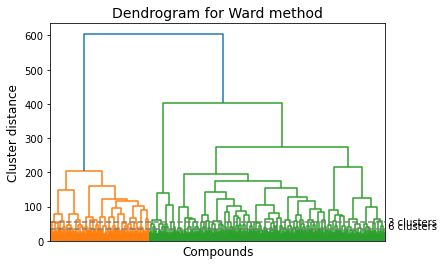

In [8]:
import matplotlib.pyplot as plt
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [34.5,34.5], '--', c='gray')
ax.plot(bounds, [55,55], '--', c='gray')
ax.text(bounds[1], 55, ' 3 clusters', va='center')
ax.text(bounds[1], 34.5, ' 6 clusters')

plt.xlabel('Compounds', fontsize=12)
plt.xticks([])
plt.ylabel('Cluster distance', fontsize=12)
plt.title('Dendrogram for Ward method', fontsize=14)

## RDKit 聚类(abandoned)

In [17]:
from rdkit import DataStructs
from rdkit.Chem.Fingerprints.ClusterMols import GetDistanceMatrix

data = [i for i in zip(df['id'], fps)]

def distij(i, j):
    return 1 - DataStructs.DiceSimilarity(i, j)
with timing("testing"):
    dist_mat = GetDistanceMatrix(data, distij)

In [18]:
dist_mat

array([0.84745763, 0.86206897, 0.84745763, ..., 0.22641509, 0.22641509,
       1.        ])

## Kmeans
### kmeans直接对bit vector聚类

2022-07-21 21:25:24.745 | INFO     | data.tools.utils:timing:25 - Started kmeans+pca
2022-07-21 21:29:02.804 | INFO     | data.tools.utils:timing:29 - Finished kmeans+pca in 218.057 seconds


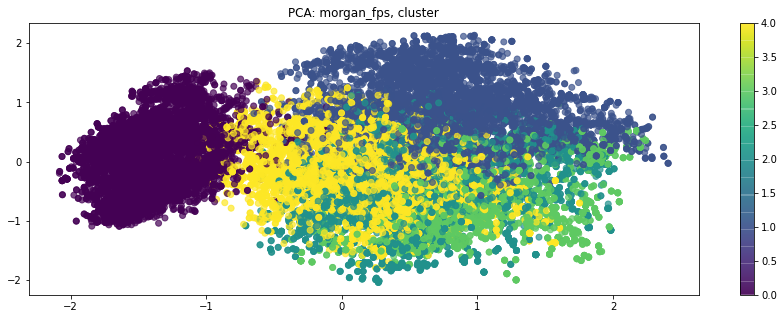

In [13]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# kmeans
with utils.timing("kmeans+pca"):
    kmeans = KMeans(n_clusters=5, n_jobs=-1)
    kmeans.fit(fps)
    # PCA
    pca = PCA(n_components = 2)
    decomp = pca.fit_transform(fps)

x = decomp[:,0]
y = decomp[:,1]
#visual
plt.figure(figsize=(15,5))

# plt.subplot(1,2,1)
plt.scatter(x, y, c= kmeans.labels_, alpha=0.7)
plt.title("PCA: morgan_fps, cluster")
plt.colorbar()

In [16]:
df['cluster'] = kmeans.predict(fps)
df

,id,base64,cluster
0,PV-000052903069_1_T1,4P///wAIAAAdAAAAApyCoG4U2QBUaQFsGBg4mBCmShiUDN...,1
1,PV-000052903083_1_T1,4P///wAIAAAeAAAAApyCoG4FAVRpAYZSmAIMWkpKrgwkqg...,1
2,PV-000052910765_1_T1,4P///wAIAAAdAAAAApyCdCAIbvUABlRpAYZSmBCmSq4MgE...,1
3,PV-000057271738_1_T1,4P///wAIAAAeAAAAApxJAG4FAVRpAVwoohgmBhCmSrwkJQ...,1
4,PV-000058306285_1_T1,4P///wAIAAAdAAAAAkBaUtCE8QRcKHJIJgYQpkq2BCQlAA...,1
...,...,...,...
30006,Z993678890_2_T1,4P///wAIAAAfAAAAAhaESiSyvqKgcQBmVoZCqBCKGkquDK...,1
30007,Z995249314_1_T1,4P///wAIAAAXAAAAAhaESthuyr0CCrQoBjqNAGa2BCRBAN...,0
30008,Z995249314_2_T1,4P///wAIAAAXAAAAAhaESthuyr0CCrQoBjqNAGa2BCRBAN...,0
30009,Z995479272_1_T1,4P///wAIAAAeAAAAAk5MSQDtALEAFQEookgQphA+QiZSCh...,1


### MiniBatchKmeans 测试

In [ ]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA


# kmeans
with utils.timing("kmeans+pca"):
    # mb_kmeans = MiniBatchKMeans(n_clusters=8, max_iter=200)
    # mb_kmeans.fit(fps)
    # PCA
    pca = PCA(n_components = 2)
    decomp = pca.fit_transform(fps)


#visual
plt.figure(figsize=(15,5))
for col,row in zip(range(3),range(3)):
    x = decomp[:,col]
    y = decomp[:,row]

    plt.subplot(3,3,col*3+row+1)
    # plt.scatter(x, y, c= mb_kmeans.labels_, alpha=0.7)
    plt.scatter(x, y, alpha=0.7)
    plt.title("PCA: morgan_fps, cluster")
    plt.colorbar()

2022-07-22 21:30:44.046 | INFO     | data.tools.utils:timing:25 - Started kmeans+pca


### 两种kmeans对比
#### Compute clustering with MiniBatchKMeans and Kmeans

In [4]:
import time
from sklearn.cluster import MiniBatchKMeans

batch_size = 1024
n_clusters = 3
X = fps

mbk = MiniBatchKMeans(
    init="k-means++",
    n_clusters=n_clusters,
    batch_size=batch_size,
    n_init=10,
    max_no_improvement=10,
    verbose=0,
)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0

from sklearn.cluster import KMeans

# kmeans
k_means = KMeans(init="k-means++", n_clusters=n_clusters, n_init=10)
t0 = time.time()
k_means.fit(fps)
t_batch = time.time() - t0

#### Establishing parity between clusters¶

In [6]:
from sklearn.metrics.pairwise import pairwise_distances_argmin

k_means_cluster_centers = k_means.cluster_centers_
order = pairwise_distances_argmin(k_means.cluster_centers_, mbk.cluster_centers_)
mbk_means_cluster_centers = mbk.cluster_centers_[order]

k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
decomp = pca.fit_transform(fps)

X = decomp
k_means_cluster_centers = pca.transform(k_means_cluster_centers)
mbk_means_cluster_centers = pca.transform(mbk_means_cluster_centers)

#### Plotting the results

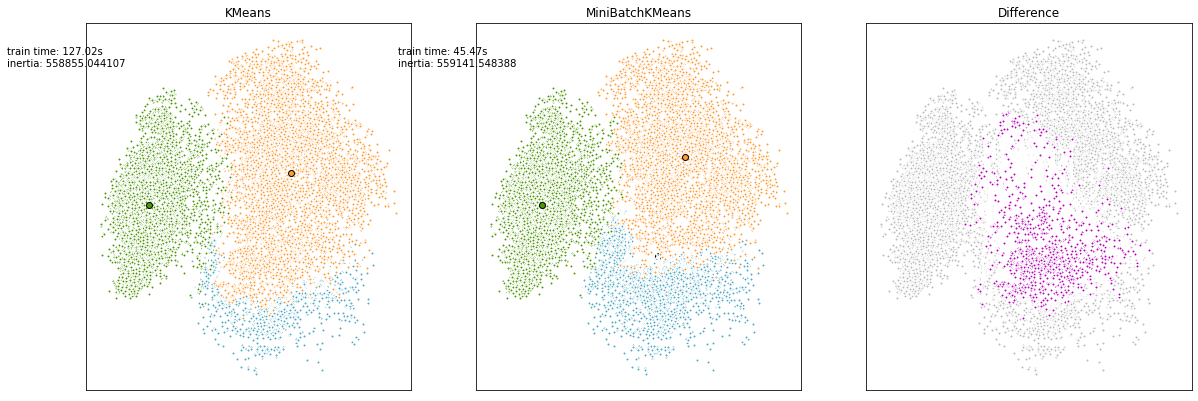

In [14]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(16, 6))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ["#4EACC5", "#FF9C34", "#4E9A06"]

# KMeans
ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".")
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
    )
ax.set_title("KMeans")
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, "train time: %.2fs\ninertia: %f" % (t_batch, k_means.inertia_))

# MiniBatchKMeans
ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == k
    cluster_center = mbk_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".")
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
    )
ax.set_title("MiniBatchKMeans")
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, "train time: %.2fs\ninertia: %f" % (t_mini_batch, mbk.inertia_))

# Initialize the different array to all False
different = mbk_means_labels == 4
ax = fig.add_subplot(1, 3, 3)

for k in range(n_clusters):
    different += (k_means_labels == k) != (mbk_means_labels == k)

identic = np.logical_not(different)
ax.plot(X[identic, 0], X[identic, 1], "w", markerfacecolor="#bbbbbb", marker=".")
ax.plot(X[different, 0], X[different, 1], "w", markerfacecolor="m", marker=".")
ax.set_title("Difference")
ax.set_xticks(())
ax.set_yticks(())

plt.show()

## Saving model

In [9]:
from sklearn.externals import joblib

# saving
joblib.dump(clustering, 'clustering.pkl')

C:\Users\asus\anaconda3\envs\20220624-virtual-clustering-py36\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['clustering.pkl']

### Loading model

In [10]:
from sklearn.externals import joblib

#loading
ward = joblib.load('clustering.pkl')

In [11]:
X

 ...]

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances_argmin

ward_cluster_centers = ward.cluster_

ward_labels = pairwise_distances_argmin(X, ward_cluster_centers)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(16, 6))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ["#4EACC5", "#FF9C34", "#4E9A06"]

# KMeans
ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".")
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
    )
ax.set_title("KMeans")
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, "train time: %.2fs\ninertia: %f" % (t_batch, k_means.inertia_))